# Chapter 4: Training Models

In [4]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)

## 4.1 Linear Regression

*Equation 4-1. Linear Regression model prediction*

$$ \hat{y} = \theta_0 + \theta_1x_1 + \theta_2x_2 + ... + \theta_nx_n$$  

where:
- $\hat{y}$ is the predicted value
- $n$ is the number of features
- $x_i$ is the ith feature value.
- $\theta_j$ is the jth model parameter (including the bias term $\theta_0$ and the feature weights)

*Equation 4-2. Linear Regression model prediction (vectorized form)*

$$ \hat{y} = h_\theta(x) = \vec{\theta} \cdot \vec{x} $$

where:
- $\vec{\theta}$ is the model's parameter vector
- $\vec{x}$ is the instance's feature vector, with $x_0$ always equal to 1
- $h_\theta$ is the hypothesis function

> Note: Vectors are often represented as *column vectors* so prediction is $\hat{y} = \theta^T x$, (matrix multiplication).  

To measure how well (or poorly) the model fits to the training data, find the value of $\theta$ that minimizes the Root Mean Square Error (RMSE) / Mean Squared Error (MSE) - value that minimizes the function also minimizes the square root.

*Equation 4-3. MSE cost function function for a Linear Regression model*

$$ MSE(X, h_\theta) = \frac{1}{m} \sum_{i=1}^{m} (\theta^T x^{(i)} - y^{(i)})^2$$

### 4.1.1 The Normal Equation

The `Normal Equation` is a closed-form solution that minimizes the cost function and finds the value of $\theta$.

*Equation 4-4. Normal Equation*

$$ \hat{\theta} = (X^T X)^{-1} X^T \vec{y}$$

where:
- $\hat{\theta}$ is the value of $\theta$ that minimizes the cost function.
- $\vec{y}$ is the vector of target values containing $y^{(1)}$ to $y^{(m)}$.

Let's generate some linear-looking data to test this equation.

In [5]:
import numpy as np

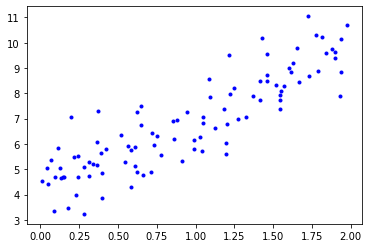

In [6]:
X = 2*np.random.rand(100, 1)
y = 4 + 3*X + np.random.randn(100, 1)

plt.plot(X, y, "b.")
plt.show()

Compute $\hat{\theta}$ using Normal Equation and `inv()` from NumPy's linear algebra module (`np.linalg`) to compute the inverse of a matrix.

In [7]:
# np.c_ concatenates along vertical axis (columns) 1's vector + X vector
# Use @ for matrix multiplication, much clearer to read than .dot()
# X_b = 'X bias' as it includes the bias term

X_b = np.c_[np.ones((100, 1)), X] # add x0 = 1 to each instance
theta_best = np.linalg.inv(X_b.T@X_b) @ X_b.T @ y
theta_best

array([[4.21509616],
       [2.77011339]])

In [8]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]
y_predict = X_new_b @ theta_best
y_predict

array([[4.21509616],
       [9.75532293]])

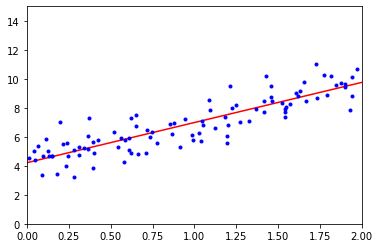

In [9]:
plt.plot(X_new, y_predict, "r-")
plt.plot(X, y, "b.")
plt.axis([0, 2, 0, 15])
plt.show()

In [10]:
from sklearn.linear_model import LinearRegression

In [11]:
lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.21509616]), array([[2.77011339]]))

In [12]:
lin_reg.predict(X_new)

array([[4.21509616],
       [9.75532293]])

> Note: Scikit-Learn separates the bias term (`intercept_`) from the feature weights (`coef_`).

`LinearRegression` class is based on `scipy.linalg.lstsq()` ("least squares").

In [13]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[4.21509616],
       [2.77011339]])

This function computes $\hat{\theta} = X^+ \vec{y}$, where $X^+$ is the pseudoinverse of $X$. Use `np.linalg.pinv()` to compute the pseudoinverse directly.

In [14]:
np.linalg.pinv(X_b) @ y

array([[4.21509616],
       [2.77011339]])

The pseudoinverse is computed using *Singular Value Decomposition (SVD)*. This approach is more efficient than computing the Normal Equation.

> Note: The Normal Equation may not work if the matrix $X^T X$ is not invertible (singular), such as if $m<n$ or if some features are redundant, but the pseudoinverse is always defined.

### 4.1.2 Computational Complexity

The Normal Equation computes the inverse $X^T X$, $ (n+1) \times (n+1)$ matrix. The *computational complexity* of inverting such a matrix is typically $O(n^{2.4})$ - $O(n^3)$. So if you double the number of features, you multiply the computation by roughly 5.3 to 8.

The SVD approach used by Scikit-Learn's `LinearRegression` is about $O(n^2)$.

> Note: Both the Normal Equation and SVD get very slow when the number of features grows large (100,000). But both are linear ($O(m)$) to the number of instances in the training set so they handle large training sets efficiently.
Ie. $\uparrow$n features, slower performance. $\uparrow$m examples, still efficient.

## 4.2 Gradient Descent

Gradient Descent measures the local gradient of the error function with regard to the parameter $\vec{\theta}$ and goes in the direction of descending gradient. Once the gradient is 0, you have reached a minimum!

Problems with Gradient Descent:
- Can converge to a *local minimum* and not *global minimum*
- With small learning rate $\alpha$, can take long to reach a minimum
- With large learning rate $\alpha$, can overshoot and diverge
- With plateaus, each gradient descent step is very small and takes long time

The MSE cost function for a Linear Regression model is a *convex function*, meaning that local minimum = global maximum and is guaranteed to approach the global min. given enough steps and learning rate is not too high.

> Note: When using Gradient Descent, you should ensure that all features have a similar scale (eg. using Scikit-Learn's `StandardScaler`). When scales are mismatched, smaller values will take a longer time to converge.

### 4.2.1 Batch Gradient Descent

*Equation 4-5. Partial derivatives of the cost function*

$$ \frac{\partial}{\partial\theta_j}MSE(\theta) = \frac{2}{m} \sum_{i=1}^{m}{(\theta^T \mathbf{x^{(i)}} - y^{(i)}) x_j^{(i)}} $$

*Equation 4-6. Gradient vector of the cost function*

$$ 
\nabla_\theta MSE(\theta)
=
\begin{pmatrix}
\frac{\partial}{\partial\theta_0} MSE(\theta) \\
\frac{\partial}{\partial\theta_1} MSE(\theta) \\
\vdots \\
\frac{\partial}{\partial\theta_n} MSE(\theta)
\end{pmatrix}
=
\frac{2}{m} \mathbf{X}^T
(\mathbf{X\theta} - \mathbf{y})
$$

> Note: Gradient vector involves the full training set $\mathbf{X}$,
>> Slow, when $\uparrow\uparrow m $ training examples
>>
>> Fast, when $\uparrow\uparrow n$ features (more efficient than Normal Equation/SVD decomposition)

Gradient vector points uphill ($+$) so go in opposite direction to go downhill ($-$) by multiplying by learning rate $\eta$ and subtracting the gradient from $\theta$.

*Equation-4-7. Gradient Descent step*

$$ 
\theta^{(next \: step)} = \theta -
\eta \nabla_\theta MSE(\theta)
$$

In [15]:
eta = 0.1 # learning rate
n_iterations = 1000
m = 100

theta = np.random.randn(2, 1) # random initialization

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T @ (X_b @ theta - y)
    theta = theta - eta * gradients

theta

array([[4.21509616],
       [2.77011339]])

To find a good learning rate, you can use `grid search`. However, limit the number of iterations so that grid search can eliminate models that take too long to converge.

How many iterations? Set a very large number of iterations but interrupt the algorithm when the gradient vector becomes tiny, $ << \epsilon $, where $\epsilon$ is the tolerance.

> **Convergence Rate**
>> When the cost function is convex and slope does not change abruptly, Batch Gradient Descent with a fixed learning rate will converge to optimal solution.
>>
>> It can take $O(1/\epsilon)$ to reach optimum within range of $\epsilon$.  
>> If you divide tolerance by 10 for more precision, it may have to run 10x longer.

### 4.2.2 Stochastic Gradient Descent

*Stochastic Gradient Descent* picks a random instance in the training set at every step and computes the gradients based only on that single instance.

Stochastic Gradient Descent has a better chance of finding the global minimum than Batch Gradient Descent.

Start with a high learning rate to escape any local minima and then gradually reduce to settle at the minimum.

In [18]:
n_epochs = 50
t0, t1 = 5, 50 # learning schedule hyperparameters

def learning_schedule(t):
    return t0 / (t+t1)

theta = np.random.randn(2, 1) # random initialization

for epoch in range(n_epochs):
    for i in range(m):
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2*xi.T@(xi@theta - yi)
        eta = learning_schedule(epoch*m + 1)
        theta = theta - eta*gradients
theta

array([[4.20758642],
       [2.81796585]])

> Note: Instances are picked randomly, so some may be picked several times per epoch, while others may not be picked at all. You can shuffle the training set, go through instance by instance, and then shuffle again, but this generally converges more slowly.

Use Scikit-Learn's `SGDRegressor` to perform Linear Regression using Stochastic GD.

- `max_iter=1000, tol=1e-3` runs for 1,000 epochs or until the loss drops by less than 0.001.
- `eta0=0.1` starts with  learning rate of 0.1 and default learning schedule (Scikit-Learn's default).
- `penalty=None` does not use any regularization.

In [19]:
from sklearn.linear_model import SGDRegressor

In [20]:
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1)
sgd_reg.fit(X, y.ravel())
sgd_reg.intercept_, sgd_reg.coef_

(array([4.21321447]), array([2.78639198]))

### 4.2.3 Mini-batch Gradient Descent

At each step, instead of computing the gradients based on the full training set (Batch GD) or based on one instance (Stochastic GD), Mini-batch GD computes the gradients on small random sets of instances called *mini-batches*.

Mini-batch GD will end up walking around a bit closer to the minimum thatn Stochastic GD, but may be harder to escape a local minima.

Mini-batch is the middle ground between Batch/Stochastic.

## 4.3 Polynomial Regression

For data that is more complex than a straight line, add powers of each feature as new features then train a linear model on this extended set of features - called *Polynomial Regression*.

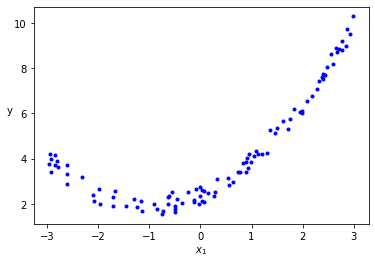

In [31]:
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5*X**2 + X + 2 + np.random.rand(m, 1)

plt.plot(X, y, "b.")
plt.xlabel("$x_1$")
plt.ylabel("y", rotation=0)
plt.show()

Use Scikit-Learn's `PolynomialFeatures` to transform our training data, adding the square (2nd-degree polynomial) of each feature in the training set as a new feature.

In [32]:
from sklearn.preprocessing import PolynomialFeatures

In [33]:
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0]

array([2.68224167])

In [34]:
X_poly[0]

array([2.68224167, 7.19442037])

Now use `LinearRegression` to fit this extended training data.

In [35]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([2.40045228]), array([[0.98552628, 0.51117359]]))

The model estimated $ \hat{y} = 0.511x_1^2 + 0.99x_1 + 2.40 $ when the original function was $ y = 0.5x_1^2 + 1.0x_1 + 2.0 + GaussianNoise $

`PolynomialFeatures` adds all combinations of features up to the given degree. For example for `degree=3`, ($ a^2, a^3, b^2, b^3, ab, a^2b, ab^2). $

> Note: `PolynomialFeatures(degree=d)` transforms into $ \frac{(n+d)!} {d!n!} $ features, so beware of the combinatorial explosion.

## 4.4 Learning Curves

## 4.5 Regularized Linear Models

### 4.5.1 Ridge Regression

### 4.5.2 Lasso Regression

### 4.5.3 Elastic Net

### 4.5.4 Early Stopping

## 4.6 Logistic Regression

### 4.6.1 Estimating Probabilities

### 4.6.2 Training and Cost Function

### 4.6.3 Decision Boundaries

### 4.6.4 Softmax Regression